<a href="https://colab.research.google.com/github/KimGriezmann/Bigcontest_2021/blob/master/working_space_SeongGwan/%EB%B9%85%EC%BD%98_EDA_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **빅콘테스트**

2021.08.13. 

랜덤포레스트로 안타일지, 아웃일지, 타석에 포함안되는 타구일지를 예측 (정확도 0.98) </br>
타구속도를 고정해놓고 어떤 발사각도에서 타율이 0.5가 넘는지 출력해봄</br>
이렇게 하면 데이터가 없는 구간도 예측 가능하지만, 120km/h + -52º 도 안타로 예측하는 등 아웃라이어에 이상하게 반응함


> ## 1. Dataset Load



---


### **<데이터 목록>**


*   HTS : 타구 트래킹 데이터 (2018~2021) - csv
*   Player : 선수 (2018_2021) - csv
*   Hitter : 타자 기본 (2018~2021) - csv
*   Team : 팀 - csv
*   Schedule : 경기일정 (2021) - csv

*   val : 평가데이터 - xlsx

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def create_df():

  #연도별 데이터 경로
  HTS_dir = '/content/drive/MyDrive/빅콘테스트/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS'
  Player_dir = '/content/drive/MyDrive/빅콘테스트/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수'
  Hitter_dir = '/content/drive/MyDrive/빅콘테스트/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본'
  #단일 데이터 경로
  Team_dir = '/content/drive/MyDrive/빅콘테스트/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_팀.csv'
  Schedule_dir = '/content/drive/MyDrive/빅콘테스트/01_제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_경기일정_2021.csv'
  val_dir = '/content/drive/MyDrive/빅콘테스트/02_평가데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_평가데이터.xlsx'

  year = [2018, 2019, 2020, 2021]

  for i in year:
    globals()['HTS_{}'.format(i)]     = pd.read_csv(HTS_dir + '_' + str(i) + '.csv', encoding='CP949')
    globals()['Player_{}'.format(i)]  = pd.read_csv(Player_dir + '_' + str(i) + '.csv', encoding='CP949')
    globals()['Hitter_{}'.format(i)]  = pd.read_csv(Hitter_dir + '_' + str(i) + '.csv', encoding='CP949')

  global Team_df, Schedule_df, val_df
  Team_df = pd.read_csv(Team_dir, encoding='CP949')
  Schedule_df = pd.read_csv(Schedule_dir, encoding='CP949')
  val_df = pd.read_excel(val_dir)

######################

#연도별 데이터 하나로 통합
def concat_df():
  df_list = ['HTS', 'Player', 'Hitter']

#각 칼럼이 모두 같은지 검사 후 통합
  for i in df_list:
    if ((globals()['{}_2018'.format(i)].columns == globals()['{}_2019'.format(i)].columns).all()) and ((globals()['{}_2019'.format(i)].columns == globals()['{}_2020'.format(i)].columns).all()) and \
    ((globals()['{}_2020'.format(i)].columns == globals()['{}_2021'.format(i)].columns).all()):
      globals()['{}_df'.format(i)] = pd.concat( [ globals()['{}_2018'.format(i)], globals()['{}_2019'.format(i)], globals()['{}_2020'.format(i)], globals()['{}_2021'.format(i) ] ] )

#연도별 길이의 합이 통합된 데이터의 길이와 같은지 검사
  for i in df_list:
    if len(globals()['{}_2018'.format(i)]) + len(globals()['{}_2019'.format(i)]) + len(globals()['{}_2020'.format(i)]) + len(globals()['{}_2021'.format(i)]) == len(globals()['{}_df'.format(i)]):
      print('{} is complete!'.format(i))

######################

create_df()
concat_df()

HTS is complete!
Player is complete!
Hitter is complete!


> ## 2. Dataset Overview

### 2-1. HTS Dataset

---


#### **<칼럼 목록>**


*   GYEAR : 경기년도
*   G_ID : 경기코드
*   PIT_ID : 타구코드 : 각 타구가 가지는 고유의 코드
*   PCODE : 타자코드 -> Player_df와 비교
*   T_ID : 타자 팀 코드
*   INN : 이닝
*   HIT_VEL : 타구속도(km/h)
*   HIT_AVG_VER : 발사각도
*   HIT_RESULT : 타격결과(총 17가지)
*   PIT_VEL : 상대투수 투구구속(km/h)
*   STADIUM : 경기구장

In [ ]:
HTS_df.head(3)

,GYEAR,G_ID,PIT_ID,PCODE,T_ID,INN,HIT_VEL,HIT_ANG_VER,HIT_RESULT,PIT_VEL,STADIUM
0,2018,20180324HHWO0,180324_140436,62797,HH,1,131.50,42.7,플라이,149.59,고척
1,2018,20180324HHWO0,180324_140514,76753,HH,1,135.18,9.9,1루타,148.78,고척
2,2018,20180324HHWO0,180324_140647,71752,HH,1,152.41,2.1,1루타,148.59,고척


In [ ]:
HTS_df.describe()

,GYEAR,PCODE,INN,HIT_VEL,HIT_ANG_VER,PIT_VEL
count,120745.000000,120745.000000,120745.000000,120745.000000,120745.000000,120745.00000
mean,2019.293188,69753.281916,4.935070,133.732175,17.394404,135.79528
std,1.041636,7388.967977,2.585468,21.337877,24.100255,9.21249
min,2018.000000,50054.000000,1.000000,9.880000,-68.900000,82.50000
25%,2018.000000,63963.000000,3.000000,121.680000,-1.500000,129.60000
50%,2019.000000,69209.000000,5.000000,137.700000,14.500000,137.49000
75%,2020.000000,76313.000000,7.000000,149.480000,32.200000,142.99000
max,2021.000000,99810.000000,12.000000,210.130000,89.800000,159.40000


발사각도 범위 : -68.9º ~ 89.8º -> 왜 큰 각도는 없는지 생각해보기

타구속도 범위 : 9.88km/h ~ 210.13km/h

투구속도 범위 : 82.5km/h ~ 159.4km/h


---

HIT_RESULT(17개) 확인 : 파울은 기록되지 않고, 파울플라이는 존재함

>90도 이상의 발사각도라면 파울플라이로 잡을 수 없지 않을까?

>바닥으로 떨어지는 발사각도는 69도 이상은 왜 없지?

In [ ]:
HTS_df['HIT_RESULT'].value_counts()

플라이          36540
1루타          29235
땅볼아웃         26507
2루타           8146
홈런            4732
파울플라이         4097
직선타           3602
병살타           3085
내야안타(1루타)     1810
희생플라이         1603
3루타            672
인필드플라이         331
희생번트           239
야수선택            52
번트안타            48
번트아웃            44
삼중살타             2
Name: HIT_RESULT, dtype: int64

> 각 타구결과별 타구속도, 발사각도, 투구속도 분석해보기 -> 시각화

### 2-2. Player Dataset

---


#### **<칼럼 목록>**


*   GYEAR : 시즌
*   PCODE : 타자코드
*   NAME : 이름
*   T_ID : 팀 코드
*   POSITION : 포지션(투/포/내/외)
*   AGE_VA : 나이
*   MONEY : 연봉

In [ ]:
Player_df.head(3)

,GYEAR,PCODE,NAME,T_ID,POSITION,AGE_VA,MONEY
0,2018,60100,백창수,HH,외,30,5000만원
1,2018,60105,배민관,LG,투,26,3200만원
2,2018,60140,신정락,LG,투,31,10500만원


In [ ]:
Player_df.describe()

,GYEAR,PCODE,AGE_VA
count,2639.000000,2639.000000,2639.000000
mean,2019.502463,66828.251610,26.632815
std,1.111272,7244.337608,5.079325
min,2018.000000,50009.000000,18.000000
25%,2019.000000,63260.000000,23.000000
50%,2020.000000,66469.000000,27.000000
75%,2020.000000,69705.000000,30.000000
max,2021.000000,99810.000000,42.000000


In [ ]:
Player_df[ Player_df['PCODE'] == 76232 ]

,GYEAR,PCODE,NAME,T_ID,POSITION,AGE_VA,MONEY
536,2018,76232,양의지,OB,포,31,60000만원
562,2019,76232,양의지,NC,포,32,200000만원
600,2020,76232,양의지,NC,포,33,200000만원
581,2021,76232,양의지,NC,포,34,150000만원


나이 범위 : 18세~42세
> 선수코드보다는 이름으로 보는게 더 재밌으니까 이름으로 바꿔보자

> 선수코드가 연도별로 달라지는지 확인해보고 바꾸기

### 2-3. Hitter Dataset

---


#### **<칼럼 목록>**


*   GYEAR : 시즌
*   PCODE : 타자코드
*   GAMENUM : 경기수
*   PA : 타석 수
*   AB : 타수
*   BA : 타율
*   HIT : 안타
*   HR : 홈런
*   TOTB : 루타
*   SLG : 장타율
*   SF : 희생플라이
*   BB : 볼넷(고의사구(IB) 포함
*   KK : 삼진
*   IB : 고의사구
*   HP : 사구(몸에 맞는 볼)
*   GD : 병살타

In [ ]:
Hitter_df.head(3)

,GYEAR,PCODE,GAMENUM,PA,AB,BA,HIT,HR,TOTB,SLG,SF,BB,KK,IB,HP,GD
0,2018,60100,70,169,152,0.243,37,3,63,0.414,1,12,36,0,4,5
1,2018,60184,6,10,10,0.200,2,0,3,0.300,0,0,3,0,0,0
2,2018,60288,1,1,1,0.000,0,0,0,0.000,0,0,0,0,0,0


In [ ]:
Hitter_df.describe()

,GYEAR,PCODE,GAMENUM,PA,AB,BA,HIT,HR,TOTB,SLG,SF,BB,KK,IB,HP,GD
count,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000,1098.000000
mean,2019.458106,67544.673953,58.010929,181.731330,159.855191,0.221596,43.708561,4.384335,65.802368,0.317603,1.500000,16.434426,32.405282,0.525501,2.458106,3.663934
std,1.094685,7204.389367,45.691006,189.254479,166.481433,0.100197,50.373561,7.449606,79.592387,0.156393,2.238411,19.175811,32.643298,1.276599,3.595370,4.513021
min,2018.000000,50054.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.250000,63260.000000,15.000000,24.000000,21.250000,0.179500,4.000000,0.000000,5.000000,0.238000,0.000000,2.000000,6.000000,0.000000,0.000000,0.000000
50%,2019.000000,66506.000000,50.500000,105.500000,90.500000,0.243000,21.000000,1.000000,29.000000,0.333000,1.000000,8.000000,22.000000,0.000000,1.000000,2.000000
75%,2020.000000,73136.000000,97.000000,304.500000,269.000000,0.280750,72.000000,5.000000,104.000000,0.418000,2.000000,27.000000,50.000000,0.000000,4.000000,6.000000
max,2021.000000,99810.000000,144.000000,668.000000,586.000000,1.000000,199.000000,47.000000,374.000000,1.000000,12.000000,91.000000,154.000000,10.000000,26.000000,26.000000


경기수 범위 : 1경기 ~ 144경기

총 타석 범위 : 1타석 ~ 668타석

포함 타석 범위 : ~ 586타석

안타 범위 : ~ 199개

홈런 범위 : ~ 47개

루타 범위 : ~ 374루타

희플 범위 : ~ 12개

볼넷 범위 : ~ 91개

삼진 범위 : ~ 154개

고의사구 범위 : ~ 10개

사구 범위 : ~ 26개

병살타 범위 : ~ 26개

---

> 선수데이터에는 있는데 타자기본데이터에는 없는 선수가 있을까?

> 연도별 데이터셋으로 확인해보기

### 2-4. Team Dataset

---


#### **<칼럼 목록>**


*   SEASON_ID : 시즌
*   T_ID : 팀 코드
*   T_NM : 팀 이름

In [ ]:
Team_df.head(3)

,SEASON_ID,T_ID,T_NM
0,2016,HH,한화
1,2016,HT,KIA
2,2016,KT,KT


In [ ]:
print(Team_df['T_ID'].value_counts())

KT    6
NC    6
LT    6
OB    6
HH    6
SS    6
LG    6
WO    6
SK    6
HT    6
Name: T_ID, dtype: int64


In [ ]:
Team_df['T_NM'].value_counts()

KT     6
삼성     6
NC     6
롯데     6
LG     6
한화     6
KIA    6
두산     6
SK     5
키움     3
넥센     3
SSG    1
Name: T_NM, dtype: int64

In [ ]:
Team_df[Team_df ['T_ID'] == 'WO']

,SEASON_ID,T_ID,T_NM
9,2016,WO,넥센
19,2017,WO,넥센
29,2018,WO,넥센
39,2019,WO,키움
49,2020,WO,키움
59,2021,WO,키움


In [ ]:
Team_df[Team_df ['T_ID'] == 'SK']

,SEASON_ID,T_ID,T_NM
7,2016,SK,SK
17,2017,SK,SK
27,2018,SK,SK
37,2019,SK,SK
47,2020,SK,SK
57,2021,SK,SSG


WO : 키움 -> 넥센 (2019) / SK : SK -> SSG (2021)

> 이 데이터는 쓸 일 없을듯

### 2-5. Schedule Dataset

---


#### **<칼럼 목록>**


*   G_ID : 경기 코드 - 날짜, 원정팀, 홈팀, 헤더
*   GDAY_DS : 경기 날짜 - yyyymmdd.헤더
*   VISIT_KEY : 팀 이름
*   VISIT_KEY : 원정팀 코드
*   HOME__KEY : 홈팀 코드
*   HEADER_NO : 해더 번호(더블헤더일 경우)
*   GWEEK : 요일
*   STADIUM : 구장
*   ACG : 1-완료, 2-진행예정

In [ ]:
Schedule_df.head(3)

,G_ID,GDAY_DS,VISIT_KEY,HOME_KEY,HEADER_NO,GWEEK,STADIUM,ACG
0,20210403SSWO0,20210403.0,SS,WO,0,토,고척,1
1,20210404HHKT0,20210404.0,HH,KT,0,일,수원,1
2,20210404HTOB0,20210404.0,HT,OB,0,일,잠실,1


In [ ]:
Schedule_df[Schedule_df['ACG'] == 1]

,G_ID,GDAY_DS,VISIT_KEY,HOME_KEY,HEADER_NO,GWEEK,STADIUM,ACG
0,20210403SSWO0,20210403.0,SS,WO,0,토,고척,1
1,20210404HHKT0,20210404.0,HH,KT,0,일,수원,1
2,20210404HTOB0,20210404.0,HT,OB,0,일,잠실,1
3,20210404LGNC0,20210404.0,LG,NC,0,일,창원,1
4,20210404LTSK0,20210404.0,LT,SK,0,일,문학,1
...,...,...,...,...,...,...,...,...
379,20210710HHSK0,20210710.0,HH,SK,0,토,문학,1
380,20210710LTSS0,20210710.0,LT,SS,0,토,대구,1
381,20210711HHSK0,20210711.0,HH,SK,0,일,문학,1
382,20210711KTHT0,20210711.0,KT,HT,0,일,광주,1


In [ ]:
Schedule_df[Schedule_df['ACG'] == 2]

,G_ID,GDAY_DS,VISIT_KEY,HOME_KEY,HEADER_NO,GWEEK,STADIUM,ACG
384,20210810HHHT0,20210810.0,HH,HT,0,화,광주,2
385,20210810KTWO0,20210810.0,KT,WO,0,화,고척,2
386,20210810LTNC0,20210810.0,LT,NC,0,화,창원,2
387,20210810OBSS0,20210810.0,OB,SS,0,화,대구,2
388,20210810SKLG0,20210810.0,SK,LG,0,화,잠실,2
...,...,...,...,...,...,...,...,...
715,NaN,NaN,KT,WO,0,NaN,고척,2
716,NaN,NaN,NC,WO,0,NaN,고척,2
717,NaN,NaN,NC,WO,0,NaN,고척,2
718,NaN,NaN,NC,WO,0,NaN,고척,2


In [ ]:
Schedule_df[Schedule_df['G_ID'].isnull()]

,G_ID,GDAY_DS,VISIT_KEY,HOME_KEY,HEADER_NO,GWEEK,STADIUM,ACG
639,NaN,NaN,HT,HH,0,NaN,대전,2
640,NaN,NaN,HT,HH,0,NaN,대전,2
641,NaN,NaN,HT,HH,0,NaN,대전,2
642,NaN,NaN,LG,HH,0,NaN,대전,2
643,NaN,NaN,LG,HH,0,NaN,대전,2
...,...,...,...,...,...,...,...,...
715,NaN,NaN,KT,WO,0,NaN,고척,2
716,NaN,NaN,NC,WO,0,NaN,고척,2
717,NaN,NaN,NC,WO,0,NaN,고척,2
718,NaN,NaN,NC,WO,0,NaN,고척,2


진행완료 경기 : 2021.04.03 ~ 2021.07.11 - 384경기

진행예정 경기 : 2021.08.10 ~ 2021.10.08 - 336경기

ID가 배정되지 않은 경기 : 81경기

---

> 예측범위는 2021.09.15 ~ 2021.10.08

> 선수 OPS 예측할 때, 몇 경기 남았는지, 상대팀이 누군지 파악용으로 사용

### 2-6. Val Dataset

---


#### **<칼럼 목록>**


*   NO : 번호(1~10)
*   PCODE : 선수코드
*   OPS : 장타율 + 출루율
*   장타율
*   출루율

In [ ]:
val_df

,NO.,PCODE,OPS,장타율,출루율
0,NaN,(예시),1.09,0.68,0.417
1,1,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN
5,5,NaN,NaN,NaN,NaN
6,6,NaN,NaN,NaN,NaN
7,7,NaN,NaN,NaN,NaN
8,8,NaN,NaN,NaN,NaN
9,9,NaN,NaN,NaN,NaN


In [ ]:
#임의로 체크해봄

Player_2021[ Player_2021['PCODE'].isin([76232, 68050, 75847, 67341, 79192, 78224, 78513, 76290, 79215, 67872])]

,GYEAR,PCODE,NAME,T_ID,POSITION,AGE_VA,MONEY
427,2021,67341,이정후,WO,외,22,55000만원
448,2021,67872,로맥,SK,내,35,900000달러
455,2021,68050,강백호,KT,내,21,31000만원
576,2021,75847,최정,SK,내,34,120000만원
581,2021,76232,양의지,NC,포,34,150000만원
584,2021,76290,김현수,LG,외,33,100000만원
611,2021,78224,김재환,OB,외,32,76000만원
616,2021,78513,전준우,LT,내,35,50000만원
630,2021,79192,채은성,LG,외,31,30000만원
631,2021,79215,박건우,OB,외,30,48000만원


> 예측해야하는 선수코드는 어디서 주지?

> ## 3. Dataset Rebuilding

> ### 3-1. 선수코드 -> 이름

In [3]:
# 선수코드와 이름을 키로 중복 제거 한 후에 딕셔너리 변환해 봄

tmp = Player_df.drop_duplicates(['PCODE', 'NAME'], keep='first')
tmp2 = tmp[ ['PCODE', 'NAME'] ].set_index('PCODE').T.to_dict('list')

len(tmp2), len(tmp)

# 총 개수가 15개 차이남 (개명한 선수 때문인 듯)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  after removing the cwd from sys.path.


(1066, 1081)

In [4]:
# 하나의 선수코드에 이름이 두개 이상 배정된 경우 확인
tmp['PCODE'].value_counts() [tmp['PCODE'].value_counts() >= 2]

62263    2
63348    2
50815    2
64717    2
60100    2
68068    2
63559    2
78819    2
62895    2
62360    2
67207    2
67539    2
63103    2
63905    2
65514    2
Name: PCODE, dtype: int64

In [5]:
# 일일이 확인해 본 결과 한 선수코드에는 같은 선수만 있는 것을 확인
tmp [tmp.PCODE == 78819]

,GYEAR,PCODE,NAME,T_ID,POSITION,AGE_VA,MONEY
608,2018,78819,백인식,SK,투,30,4000만원
621,2019,78819,백청훈,SK,투,31,3000만원


In [6]:
# 선수코드로만 딕셔너리 변환
tmp = Player_df.drop_duplicates(['PCODE'], keep='last')
Player_dict = tmp[ ['PCODE', 'NAME'] ].set_index('PCODE').T.to_dict('list')

len(Player_dict), len(tmp)
#del tmp, tmp2

# 중복이 없어짐 !

(1066, 1066)

In [7]:
HTS_df['NAME'] = HTS_df['PCODE']
HTS_df = HTS_df.replace({'NAME' : Player_dict})

Hitter_df['NAME'] = Hitter_df['PCODE']
Hitter_df = Hitter_df.replace({'NAME' : Player_dict})

In [ ]:
HTS_df.head(3)

,GYEAR,G_ID,PIT_ID,PCODE,T_ID,INN,HIT_VEL,HIT_ANG_VER,HIT_RESULT,PIT_VEL,STADIUM,NAME
0,2018,20180324HHWO0,180324_140436,62797,HH,1,131.50,42.7,플라이,149.59,고척,양성우
1,2018,20180324HHWO0,180324_140514,76753,HH,1,135.18,9.9,1루타,148.78,고척,송광민
2,2018,20180324HHWO0,180324_140647,71752,HH,1,152.41,2.1,1루타,148.59,고척,김태균


In [ ]:
Hitter_df.head(3)

,GYEAR,PCODE,GAMENUM,PA,AB,BA,HIT,HR,TOTB,SLG,SF,BB,KK,IB,HP,GD,NAME
0,2018,60100,70,169,152,0.243,37,3,63,0.414,1,12,36,0,4,5,백진우
1,2018,60184,6,10,10,0.200,2,0,3,0.300,0,0,3,0,0,0,김창혁
2,2018,60288,1,1,1,0.000,0,0,0,0.000,0,0,0,0,0,0,김응민


> ### 3-2. 선수데이터 & 타자기본데이터 비교

In [ ]:
# 선수데이터의 투수를 제외한 모든 선수와 타자기본데이터의 길이 비교

tmp = Player_2018 [ Player_2018['POSITION'] != '투' ]
len(tmp), len(Hitter_2018)

# 49개 차이

(324, 275)

In [ ]:
# 없는 선수 목록
tmp[~tmp['PCODE'].isin(Hitter_2018['PCODE'])].head(5)

# 실제 스탯티즈에서 직접 검색해 본 결과 당시 타석에 서지 않은 것으로 보임

,GYEAR,PCODE,NAME,T_ID,POSITION,AGE_VA,MONEY
23,2018,60658,최병연,HT,내,31,3300만원
24,2018,60693,이준호,HT,외,30,3700만원
46,2018,61360,김도현,OB,외,25,3200만원
70,2018,62007,김지성,HT,내,32,4000만원
75,2018,62147,조윤준,LG,포,28,4000만원


> ### 3-3. 각 타구별 타구속도, 발사각도, 투구속도

In [ ]:
HTS_fly = HTS_df[HTS_df.HIT_RESULT.isin(['플라이', '희생플라이'])]
HTS_1b = HTS_df[HTS_df.HIT_RESULT=='1루타']
HTS_2b = HTS_df[HTS_df.HIT_RESULT=='2루타']
HTS_3b = HTS_df[HTS_df.HIT_RESULT=='3루타']
HTS_hr = HTS_df[HTS_df.HIT_RESULT=='홈런']
HTS_ff = HTS_df[HTS_df.HIT_RESULT=='파울플라이']
HTS_gb = HTS_df[HTS_df.HIT_RESULT.isin(['땅볼아웃','야수선택'])]
HTS_ld = HTS_df[HTS_df.HIT_RESULT=='직선타']
HTS_dp = HTS_df[HTS_df.HIT_RESULT=='병살타']
HTS_i1b = HTS_df[HTS_df.HIT_RESULT=='내야안타(1루타)']
HTS_iff = HTS_df[HTS_df.HIT_RESULT=='인필드플라이']
HTS_bh = HTS_df[HTS_df.HIT_RESULT=='번트안타']
HTS_bo = HTS_df[HTS_df.HIT_RESULT.isin(['번트아웃', '희생번트'])]

No handles with labels found to put in legend.


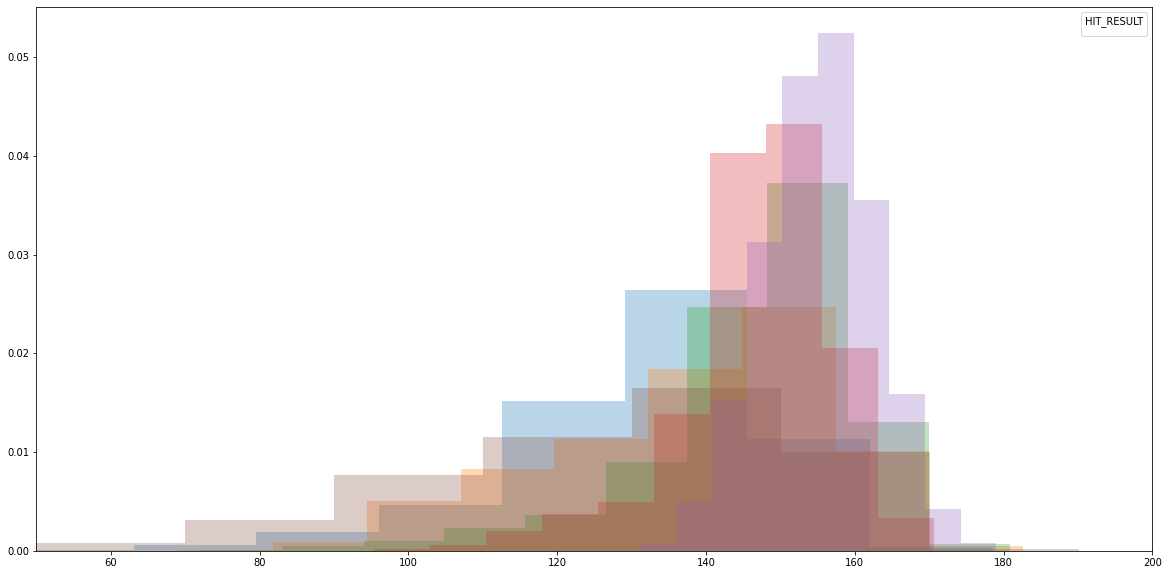

In [ ]:
plt.figure(figsize=(20,10))
plt.xlim(50,200)

plt.hist(HTS_fly['HIT_VEL'], density=True, alpha=0.3)
plt.hist(HTS_1b['HIT_VEL'], density=True, alpha=0.3)
plt.hist(HTS_2b['HIT_VEL'], density=True, alpha=0.3)
plt.hist(HTS_3b['HIT_VEL'], density=True, alpha=0.3)
plt.hist(HTS_hr['HIT_VEL'], density=True, alpha=0.3)
plt.hist(HTS_gb['HIT_VEL'], density=True, alpha=0.3)
plt.legend(title="HIT_RESULT")
plt.show()

Text(0.5, 1.0, 'Hitting Velocity Comparison')

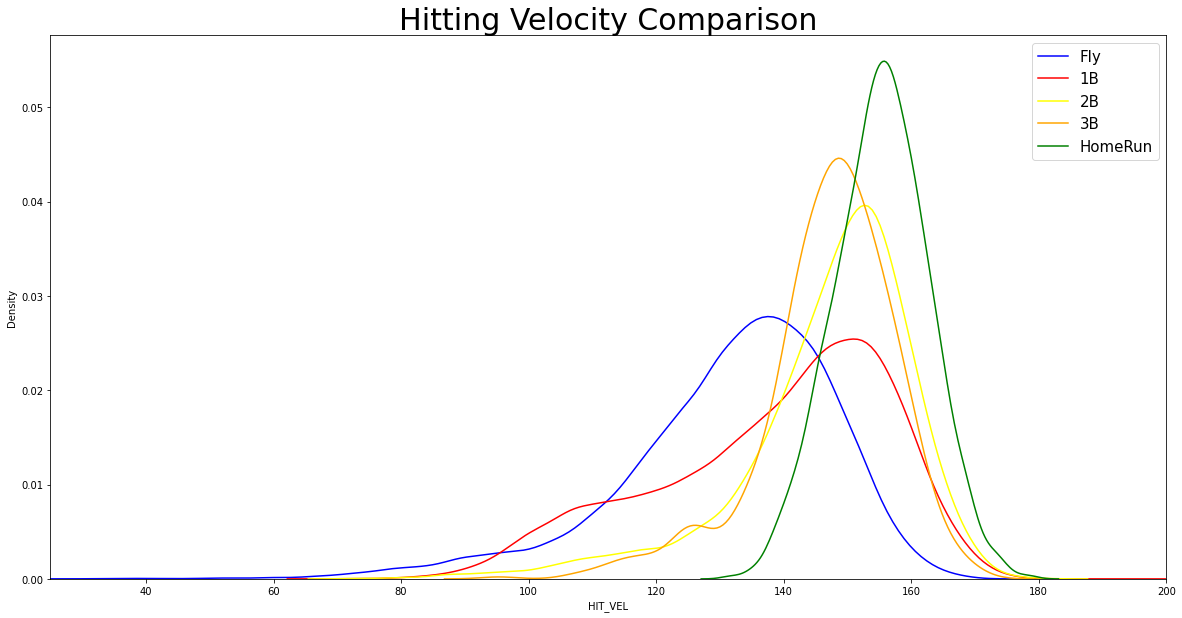

In [ ]:
ax = plt.figure(figsize=(20, 10))

ax = sns.kdeplot(HTS_fly['HIT_VEL'], color='blue', label='Fly')
ax = sns.kdeplot(HTS_1b['HIT_VEL'], color='Red', label='1B')
ax = sns.kdeplot(HTS_2b['HIT_VEL'], color='Yellow', label='2B')
ax = sns.kdeplot(HTS_3b['HIT_VEL'], color='Orange', label='3B')
ax = sns.kdeplot(HTS_hr['HIT_VEL'], color='Green', label='HomeRun')

ax.set_xlim(25, 200)
ax.legend(fontsize=15)


ax.set_title('Hitting Velocity Comparison', fontsize=30)

Text(0.5, 1.0, 'Hitting Angle Comparison')

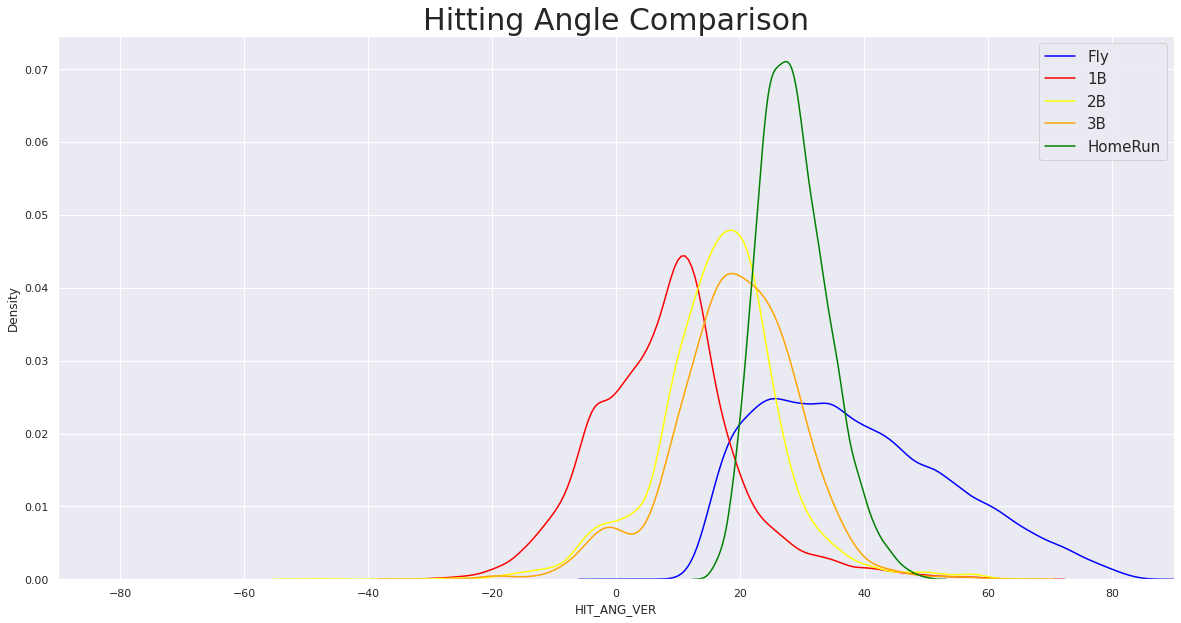

In [ ]:
ax = plt.figure(figsize=(20, 10))

ax = sns.kdeplot(HTS_fly['HIT_ANG_VER'], color='blue', label='Fly')
ax = sns.kdeplot(HTS_1b['HIT_ANG_VER'], color='Red', label='1B')
ax = sns.kdeplot(HTS_2b['HIT_ANG_VER'], color='Yellow', label='2B')
ax = sns.kdeplot(HTS_3b['HIT_ANG_VER'], color='Orange', label='3B')
ax = sns.kdeplot(HTS_hr['HIT_ANG_VER'], color='Green', label='HomeRun')

ax.set_xlim(-90, 90)
ax.legend(fontsize=15)


ax.set_title('Hitting Angle Comparison', fontsize=30)

Text(0.5, 1.0, 'Pitch Velocity Comparison')

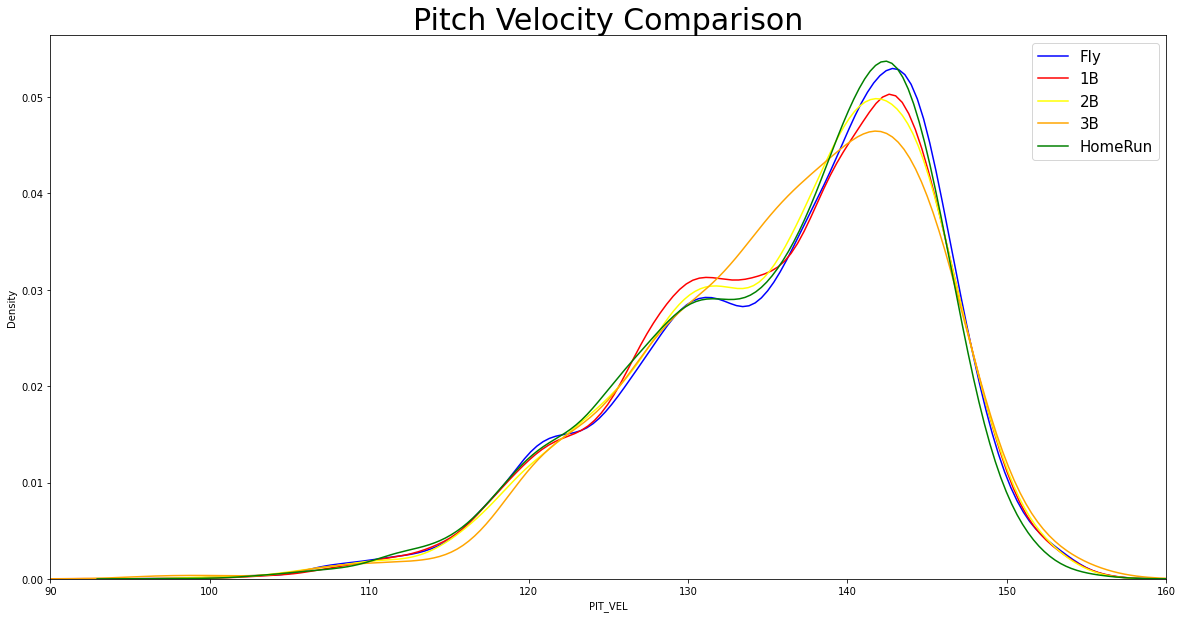

In [ ]:
ax = plt.figure(figsize=(20, 10))

ax = sns.kdeplot(HTS_fly['PIT_VEL'], color='blue', label='Fly')
ax = sns.kdeplot(HTS_1b['PIT_VEL'], color='Red', label='1B')
ax = sns.kdeplot(HTS_2b['PIT_VEL'], color='Yellow', label='2B')
ax = sns.kdeplot(HTS_3b['PIT_VEL'], color='Orange', label='3B')
ax = sns.kdeplot(HTS_hr['PIT_VEL'], color='Green', label='HomeRun')

ax.set_xlim(90, 160)
ax.legend(fontsize=15)


ax.set_title('Pitch Velocity Comparison', fontsize=30)

> ## 4. KBO의 배럴기준 찾아보기
---
타율 0.5이상 장타율 1.5이상을 기준으로

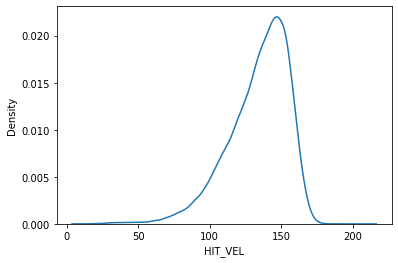

In [ ]:
sns.kdeplot(HTS_df.HIT_VEL)

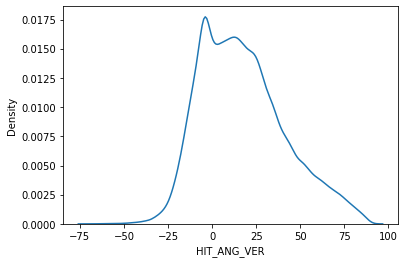

In [ ]:
sns.kdeplot(HTS_df.HIT_ANG_VER)

In [ ]:
# 범주화하는 기준 바꿔가면서 살펴보기

bins_vel = [9.88, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 155, 160, 165, 170, 175, 180, 185, 211]
bins_ang = [-68.9, -30, -20, -10, 0, 10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 89.8]

HTS_df['HIT_VEL_CUT']  = pd.cut(HTS_df.HIT_VEL, bins = bins_vel, labels = bins_vel[1:])
HTS_df['HIT_ANG_CUT']  = pd.cut(HTS_df.HIT_ANG_VER, bins = bins_ang, labels = bins_ang[1:])

# 각 클래스별 개수 확인
HTS_df['HIT_VEL_CUT'].value_counts().to_frame().style.background_gradient(cmap='summer')

,HIT_VEL_CUT
150,26073
140,21964
130,16034
155,12466
120,11360
160,9099
110,7629
165,4909
100,4192
90,2248


In [ ]:
HTS_df['HIT_ANG_CUT'].value_counts().to_frame().style.background_gradient(cmap='summer')

,HIT_ANG_CUT
0,19880
20,18990
10,18712
-10,10013
25,8928
30,8026
35,6581
40,5269
45,4395
70,4057


In [ ]:
# '타구속도/발사각도' 칼럼 생성
HTS_df['HIT_cat'] = HTS_df["HIT_VEL_CUT"].astype(str).str.cat( HTS_df['HIT_ANG_CUT'].astype(str) , sep="/")

In [ ]:
hit_result = ['1루타', '2루타', '홈런', '내야안타(1루타)', '3루타', '번트안타']
out_result = ['플라이', '땅볼아웃', '파울플라이', '직선타', '병살타', '인필드플라이', '번트아웃', '삼중살타']
ext_result = ['희생플라이', '희생번트', '야수선택']

Barrel_df = pd.DataFrame()

for i in range(1, len(bins_vel)):
    for j in range(1, len(bins_ang)):
        tmp_level = str(bins_vel[i]) + "/" + str(bins_ang[j])
        tmp = HTS_df[ HTS_df['HIT_cat'] == tmp_level ]
        total_num = tmp[tmp.HIT_RESULT.isin(ext_result) == False].shape[0]
        hit_num = tmp[tmp.HIT_RESULT.isin(hit_result)].shape[0]
        out_num = tmp[tmp.HIT_RESULT.isin(out_result)].shape[0]

        B1_num = tmp[tmp.HIT_RESULT.isin(['1루타', '내야안타(1루타)', '번트안타']) ].shape[0]
        B2_num = tmp[tmp.HIT_RESULT == '2루타'].shape[0]
        B3_num = tmp[tmp.HIT_RESULT == '3루타'].shape[0]
        HR_num = tmp[tmp.HIT_RESULT == '홈런'].shape[0]

        HA_tmp = hit_num / total_num if total_num != 0 else 0
        SLG_tmp = (B1_num + 2*B2_num + 3*B3_num + 4*HR_num) / total_num if total_num != 0 else 0

        Barrel_df = Barrel_df.append( {'VEL/ANG':tmp_level, 'HA':HA_tmp, 'SLG':SLG_tmp}, ignore_index=True )

155/25, 155/30, 155/35, 160/25, 160/30, 160/35, 160/40, 165/25, 165/30, 165/35, 165/40, 170/20, 170/25, 170/30, 170/35, 170/40, 170/45, 170/50, 175/20, 175/25, 175/30, 175/35, 175/40, 180/20, 180/25, 180/30, 180/35, 180/40, 180/45, 185/20, 

In [ ]:
# 배럴타구 속도/각도 확인
Barrel_df[(Barrel_df['HA'] >=  0.5) & ( Barrel_df['SLG'] >=  1.5 )].style.background_gradient(cmap='YlGn')

,HA,SLG,VEL/ANG
176,0.657869,1.734115,155/25
177,0.720093,2.463415,155/30
178,0.585404,2.145963,155/35
193,0.833124,2.617315,160/25
194,0.893471,3.398625,160/30
195,0.737892,2.823362,160/35
196,0.504587,1.917431,160/40
210,0.929155,3.258856,165/25
211,0.960573,3.784946,165/30
212,0.919118,3.595588,165/35


## 5. 배럴 기준을 정의하기 위한 예측모델 공부

---

타구속도와 발사각도에 따른 타율/장타율 관계 분석
> 선형? 비선형? 회귀분석? 클러스터링?

In [10]:
# 범주화하는 기준 바꿔가면서 살펴보기

bins_vel = [9.88, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 211]
bins_ang = [-68.9, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 89.8]

HTS_df['HIT_VEL_CUT']  = pd.cut(HTS_df.HIT_VEL, bins = bins_vel, labels = bins_vel[1:])
HTS_df['HIT_ANG_CUT']  = pd.cut(HTS_df.HIT_ANG_VER, bins = bins_ang, labels = bins_ang[1:])

In [14]:
hit_result = ['1루타', '2루타', '홈런', '내야안타(1루타)', '3루타', '번트안타']
out_result = ['플라이', '땅볼아웃', '파울플라이', '직선타', '병살타', '인필드플라이', '번트아웃', '삼중살타']
ext_result = ['희생플라이', '희생번트', '야수선택']

Velocity_df = pd.DataFrame()
Angle_df = pd.DataFrame()

for i in range(1, len(bins_vel)):
    tmp = HTS_df[ HTS_df['HIT_VEL_CUT'] == bins_vel[i] ]
    total_num = tmp[tmp.HIT_RESULT.isin(ext_result) == False].shape[0]
    hit_num = tmp[tmp.HIT_RESULT.isin(hit_result)].shape[0]
    out_num = tmp[tmp.HIT_RESULT.isin(out_result)].shape[0]

    B1_num = tmp[tmp.HIT_RESULT.isin(['1루타', '내야안타(1루타)', '번트안타']) ].shape[0]
    B2_num = tmp[tmp.HIT_RESULT == '2루타'].shape[0]
    B3_num = tmp[tmp.HIT_RESULT == '3루타'].shape[0]
    HR_num = tmp[tmp.HIT_RESULT == '홈런'].shape[0]

    HA_tmp = hit_num / total_num if total_num != 0 else 0
    SLG_tmp = (B1_num + 2*B2_num + 3*B3_num + 4*HR_num) / total_num if total_num != 0 else 0

    Velocity_df = Velocity_df.append( {'VEL':  bins_vel[i], 'HA':HA_tmp, 'SLG':SLG_tmp}, ignore_index=True )

for i in range(1, len(bins_ang)):
    tmp = HTS_df[ HTS_df['HIT_ANG_CUT'] == bins_ang[i] ]
    total_num = tmp[tmp.HIT_RESULT.isin(ext_result) == False].shape[0]
    hit_num = tmp[tmp.HIT_RESULT.isin(hit_result)].shape[0]
    out_num = tmp[tmp.HIT_RESULT.isin(out_result)].shape[0]

    B1_num = tmp[tmp.HIT_RESULT.isin(['1루타', '내야안타(1루타)', '번트안타']) ].shape[0]
    B2_num = tmp[tmp.HIT_RESULT == '2루타'].shape[0]
    B3_num = tmp[tmp.HIT_RESULT == '3루타'].shape[0]
    HR_num = tmp[tmp.HIT_RESULT == '홈런'].shape[0]

    HA_tmp = hit_num / total_num if total_num != 0 else 0
    SLG_tmp = (B1_num + 2*B2_num + 3*B3_num + 4*HR_num) / total_num if total_num != 0 else 0

    Angle_df = Angle_df.append( {'VEL': bins_ang[i], 'HA':HA_tmp, 'SLG':SLG_tmp}, ignore_index=True )

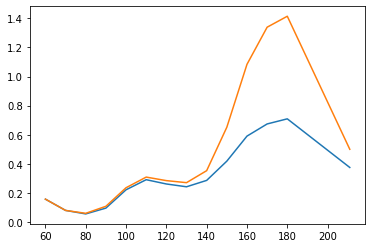

In [18]:
plt.plot(Velocity_df['VEL'], Velocity_df['HA'])
plt.plot(Velocity_df['VEL'], Velocity_df['SLG'])

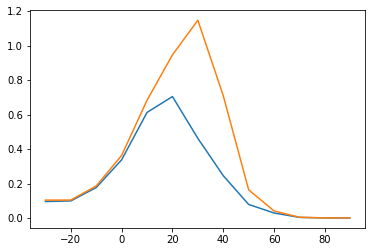

In [19]:
plt.plot(Angle_df['VEL'], Angle_df['HA'])
plt.plot(Angle_df['VEL'], Angle_df['SLG'])

In [24]:
'2루타' in hit_result

True

In [25]:
def replacing(result):
    if result in hit_result:
        result_num = 1
    elif result in out_result:
        result_num = 0
    else:
        result_num = 2
    return result_num


HTS_df['HIT_RESULT_cat'] = HTS_df['HIT_RESULT'].apply(lambda x:replacing(x))

In [37]:
x = HTS_df[['HIT_VEL', 'HIT_ANG_VER']].values
y = HTS_df['HIT_RESULT_cat'].values

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='newton-cg', max_iter=100).fit(x, y)
predict = clf.predict(x)

accuracy=(predict.reshape(-1,1) == y.reshape(-1,1)).sum()/len(y)
print(accuracy)

0.6410700236034619


In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics    
 
    # 학습 진행
forest = RandomForestClassifier(n_estimators=100)
forest.fit(x, y)
 
    # 예측
y_pred = forest.predict(x)
print(y_pred)
print(list(y))
 
    # 정확도 확인
print('정확도 :', metrics.accuracy_score(y, y_pred))

[0 1 1 ... 1 1 0]
[0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 

In [39]:
forest.feature_importances_

array([0.54756692, 0.45243308])

In [72]:
fixed_VEL = int(input())

fiveHA = []

for i in range(-30, 90):
    tmp1 = forest.predict_proba( [[fixed_VEL, i]] )[0][0]
    tmp2 = forest.predict_proba( [[fixed_VEL, i]] )[0][1]
    tmp3 = forest.predict_proba( [[fixed_VEL, i]] )[0][2]
    if tmp2 / (tmp1+tmp2) >= 0.5:
        fiveHA.append(str(fixed_VEL)+'/'+str(i))
print(fiveHA)

125
['125/-27', '125/5', '125/6', '125/7', '125/8', '125/11', '125/12', '125/13', '125/14', '125/15', '125/16', '125/17', '125/18', '125/20', '125/21', '125/23']


In [73]:
forest.predict_proba([[120, -51]])

array([[0.43, 0.57, 0.  ]])